# PPG analysis on three data sets

In [1]:
!pip install heartpy
!pip install statsmodels

In [2]:
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
from statsmodels.tsa.seasonal import STL
import heartpy as hp

In [3]:
matplotlib.rcParams["figure.figsize"] = [15, 8]

In [4]:
#Load the JSON data file

def load_type1_dataset(file):
    with open(file) as f:
        data = json.load(f)
    
    df = pd.DataFrame([data["_source"]["data"]["ppg"]['x'], data["_source"]["data"]["ppg"]['y']]).T
    df.columns=["time", "amplitude"]
    df["time"] = pd.to_timedelta(df["time"], unit='seconds')
    df.set_index("time", inplace=True)
    
    return df

def load_type2_dataset(file):
    with open(file) as f:
        data = json.load(f)
    
    # the red channel
    df = pd.DataFrame([data["_source"]["channels"][0]['time'], data["_source"]["channels"][0]['amplitude']]).T
    df.columns=["time", "amplitude"]
    df["time"] = pd.to_timedelta(df["time"], unit='seconds')
    df.set_index("time", inplace=True)
    
    return df

In [5]:
def calculate_sample_rate(df):
    """Calculates sample rate"""
    sample_rate = hp.get_samplerate_mstimer(df.index.total_seconds()*1000)
    return sample_rate

In [6]:
def scores(df, x, sample_rate):
    result = STL(df.amplitude, period=x).fit()
    try:
        working_data, measures = hp.process((result.resid + result.seasonal + result.weights).to_numpy(), sample_rate, calc_freq=True)
        return len(working_data["binary_peaklist"]), sum(working_data["binary_peaklist"])
    except:
        return None, None
    

In [7]:

def get_best_period(df, sample_rate):
    """Finds the period with the best accepted/rejected peak ration"""
    results = []
    for i in range(20,60):
        l, s = scores(df, i, sample_rate)
        if l != None:
            results.append((i, l, s))

    x= [r[0] for r in results]
    y= [(r[1]/(r[1]-r[2])) for r in results]
    
    best_score = max(y)
    best_score_index = y.index(best_score)
    best_period = x[best_score_index]

    print("Period with the best score:", best_period)
    print("Details:", results[best_score_index])
    
    return best_period


In [8]:
def calculate_measures(df):
    """Calculates measures using HeartPy"""
    sample_rate = calculate_sample_rate(df)
    best_period = get_best_period(df, sample_rate)
    
    result = STL(df.amplitude, period=best_period).fit()
    return hp.process((result.resid + result.seasonal + result.weights).to_numpy(), sample_rate, calc_freq=True)

## Measures for rnd-historical.json

/home/sistvan/anaconda3/envs/applied-ds-capstone/lib/python3.8/site-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/home/sistvan/anaconda3/envs/applied-ds-capstone/lib/python3.8/site-packages/heartpy/analysis.py:507: UserWarning: Short signal.

---------Warning:---------
too few peak-peak intervals for (reliable) frequency domain measure computation, frequency output measures are still computed but treat them with caution!

HF is usually computed over a minimum of 1 minute of good signal. LF is usually computed over a minimum of 2 minutes of good signal.The LF/HF ratio is usually computed over minimum 24 hours, although an absolute minimum of 5 min has also been suggested.

For more i

Period with the best score: 29
Details: (29, 185, 181)


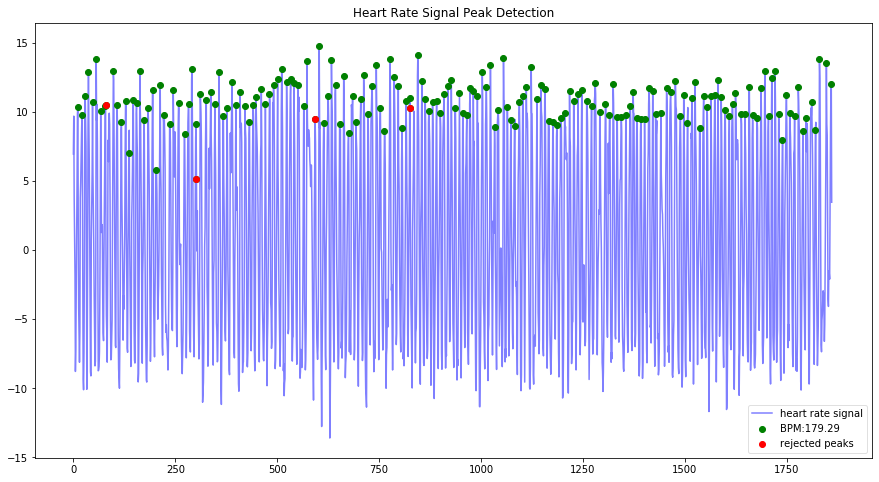

,0
bpm,179.293424
ibi,334.646964
sdnn,58.656023
sdsd,55.830575
rmssd,85.294700
pnn20,0.783626
pnn50,0.549708
hr_mad,33.313272
sd1,60.308528
sd2,56.630053


In [9]:
df = load_type1_dataset('data/rnd-historical.json')

working_data, measures = calculate_measures(df)

hp.plotter(working_data, measures)

pd.DataFrame.from_dict(measures, orient="index")

## Measures for research-v2.json

/home/sistvan/anaconda3/envs/applied-ds-capstone/lib/python3.8/site-packages/numpy/ma/core.py:5215: RuntimeWarning: Mean of empty slice.
  result = super(MaskedArray, self).mean(axis=axis,
/home/sistvan/anaconda3/envs/applied-ds-capstone/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3583: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sistvan/anaconda3/envs/applied-ds-capstone/lib/python3.8/site-packages/heartpy/analysis.py:507: UserWarning: Short signal.

---------Warning:---------
too few peak-peak intervals for (reliable) frequency domain measure computation, frequency output measures are still computed but treat them with caution!

HF is usually computed over a minimum of 1 minute of good signal. LF is usually computed over a minimum of 2 minutes of good signal.The LF/HF ratio is usually computed over minimum 24 hours, although an absolute minimum of 5 min has also been suggested.

For more info 

Period with the best score: 27
Details: (27, 68, 26)


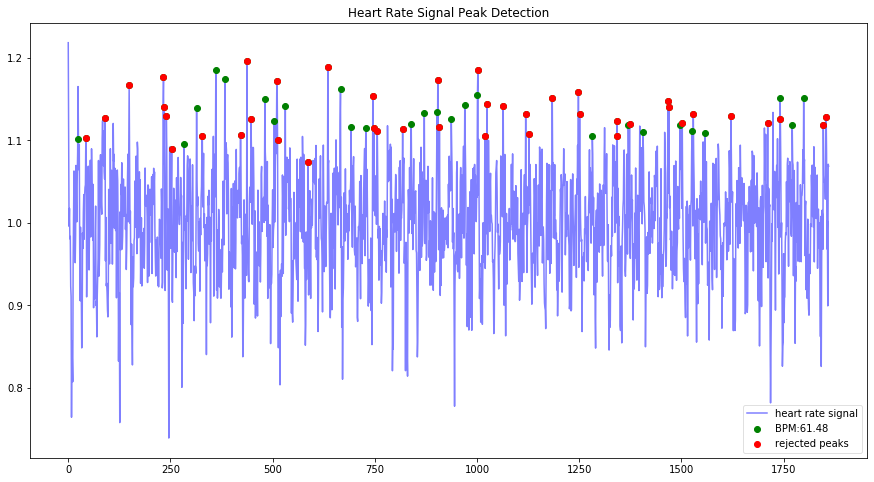

,0
bpm,61.476391
ibi,975.984417
sdnn,141.361817
sdsd,134.162282
rmssd,197.064904
pnn20,1.000000
pnn50,0.666667
hr_mad,83.275121
sd1,128.050073
sd2,19.231565


In [10]:
df = load_type1_dataset('data/research-v2.json')

working_data, measures = calculate_measures(df)

hp.plotter(working_data, measures)

pd.DataFrame.from_dict(measures, orient="index")

## Measures for signal.json

/home/sistvan/anaconda3/envs/applied-ds-capstone/lib/python3.8/site-packages/heartpy/analysis.py:507: UserWarning: Short signal.

---------Warning:---------
too few peak-peak intervals for (reliable) frequency domain measure computation, frequency output measures are still computed but treat them with caution!

HF is usually computed over a minimum of 1 minute of good signal. LF is usually computed over a minimum of 2 minutes of good signal.The LF/HF ratio is usually computed over minimum 24 hours, although an absolute minimum of 5 min has also been suggested.

For more info see: 
Shaffer, F., Ginsberg, J.P. (2017), An Overview of Heart Rate Variability Metrics and Norms.

Task Force of Pacing and Electrophysiology (1996), Heart Rate Variability, in: European Heart Journal, vol.17, issue 3, pp354-381

This warning will not repeat
  warnings.warn(msg, UserWarning)
/home/sistvan/anaconda3/envs/applied-ds-capstone/lib/python3.8/site-packages/scipy/interpolate/fitpack2.py:232: UserWarning:

Period with the best score: 20
Details: (20, 89, 88)


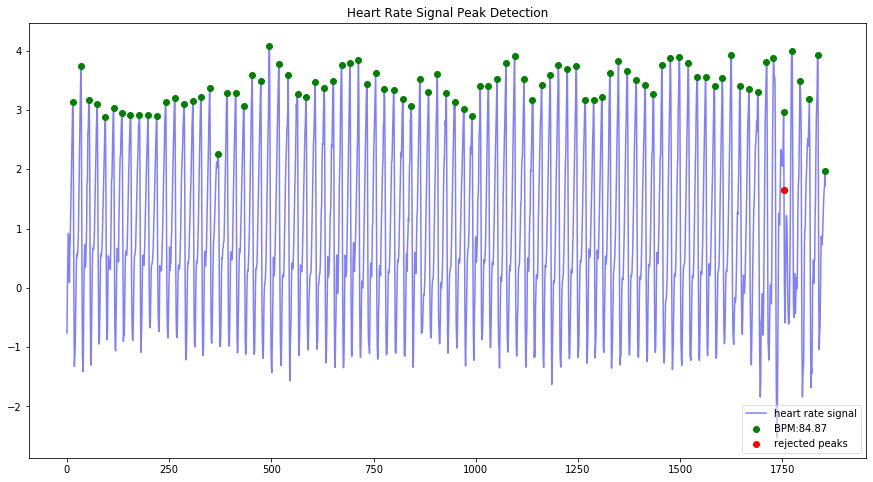

,0
bpm,84.870580
ibi,706.958759
sdnn,39.742442
sdsd,41.304008
rmssd,54.915435
pnn20,0.642857
pnn50,0.261905
hr_mad,33.405744
sd1,38.821911
sd2,36.900379


In [11]:
df = load_type2_dataset('data/signal.json')

working_data, measures = calculate_measures(df)

hp.plotter(working_data, measures)

pd.DataFrame.from_dict(measures, orient="index")